# NEW SIM DATA => Radial Profiles with COS-Holes Data
## Ben: May 12-14 ish; Nicole: June 5th 

## COS-Holes DATA & Literature DATA

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#plotting things 
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 40

# update various fontsizes to match
params = {'figure.figsize': (20, 14),
          'legend.fontsize': 20,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 16,
          'xtick.minor.size': 13,
          'ytick.major.size': 16,
          'ytick.minor.size': 13}
plt.rcParams.update(params)

import astropy.units as u
from linetools.spectralline import AbsLine
from linetools.spectra import io as lsio
from linetools.isgm.abscomponent import AbsComponent
from linetools.spectra.xspectrum1d import XSpectrum1D
from linetools.lists.linelist import LineList
import glob

import seaborn as sns
pal = sns.color_palette("pastel")

import pickle

from pymccorrelation import pymccorrelation
import linmix

from scipy.stats import kendalltau
from seaborn.algorithms import bootstrap

In [2]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [20]:
#Bring in all the COS-Holes fit data and modifying
cosholes_df = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/cosholes_df.csv')
#cosholes_df

In [21]:
#DATA frame for just the upper limits 

up_ch = cosholes_df.loc[(cosholes_df['uplim'] == 0)]
#up_ch

In [22]:
#Df of just the sums for the whole data set (use this for everything but the relative velocity plot) with no uplims 

sum_ch = cosholes_df.loc[(cosholes_df['comp'] > 0) & (cosholes_df['uplim'] == 1)]
#sum_ch

In [23]:
#Df of all the components for the whole data set (use this for just the relative velocity plot) with no uplims 
com_ch = cosholes_df.loc[(cosholes_df['comp'] < 2) & (cosholes_df['uplim'] == 1)]
#com_ch

In [7]:
#M31 Data (Project AMIGA) Detections (and taking out the MS contaminations) 

amiga_2_det_sum = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/amiga_2_det_sum.csv')
amiga_2_det_sum = amiga_2_det_sum.loc[(amiga_2_det_sum['sumlogN']!= 0)]
amiga_2_det_sum = amiga_2_det_sum.loc[amiga_2_det_sum['MS']==0]

#Calculating the Project AMIGA Rproj/Rvir so that I can add to future plot 
#making sure to use r200 as a substitute for since that is what we used 
amiga_m31_rvrir = 230 #kpc This is the value used for R200 in the paper? 

amiga_det_R = np.array(amiga_2_det_sum['Rad'])
amiga_det_RRvir = amiga_det_R/amiga_m31_rvrir

#amiga_2_det_sum

In [8]:
#M31 Data (Project AMIGA) non-detections (upper limits) and taking out the MS contamination
amiga_2_up_sum = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/amiga_2_up_sum.csv')
amiga_2_up_sum = amiga_2_up_sum.loc[(amiga_2_up_sum['sumlogN']!= 0)]
amiga_2_up_sum = amiga_2_up_sum.loc[(amiga_2_up_sum['MS']== 0)]

#Calculating the Project AMIGA Rproj/Rvir so that I can add to future plot 
amiga_up_R = np.array(amiga_2_up_sum['Rad'])
amiga_up_RRvir = amiga_up_R/amiga_m31_rvrir

#amiga_2_up_sum

In [9]:
#creating masks to separate into high and low 
low_mask, high_mask = (cosholes_df["MBH"] <= 7.6), (cosholes_df["MBH"] > 7.6)

In [10]:
#EAGLE

df_r_new_low = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/May12.MS10_11/profile_coll_kpc_EAGLE.halo.list.CIV_median.MBH50_97_2bins.MS100_110.5.0_7.375.dat",sep=" ")
df_r_new_high = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/May12.MS10_11/profile_coll_kpc_EAGLE.halo.list.CIV_median.MBH50_97_2bins.MS100_110.7.375_9.75.dat",sep=" ")

########################################################

# TNG 

df_r_new_lowtng = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/May12.MS10_11/profile_coll_kpc_TNG.halo.list.CIV_median.MBH60_104_2bins.MS100_110.6.05_8.225.dat",sep=" ")
df_r_new_hightng = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/May12.MS10_11/profile_coll_kpc_TNG.halo.list.CIV_median.MBH60_104_2bins.MS100_110.8.225_10.4.dat",sep=" ")

########################################################

# R25: New Data from Nicole (June 5th 2023)

r25_rr = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_RoverRvir_new.txt', 
                       sep=" ", header=None, names =['Rproj/Rvir'])
r25_r = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/COSholes_Rkpc.txt', 
                       sep=" ", header=None, names =['Rproj'])

#High MBH Things 
hmbh_civ = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_highMbh_logN_CIV_new.txt', 
                       sep=" ", header=None, names =['logNciv'])
hmbh_16 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_highMbh_logN_CIV_16percentile_new.txt.txt', 
                       sep=" ", header=None, names =['16per'])
hmbh_84 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_highMbh_logN_CIV_84percentile_new.txt.txt', 
                       sep=" ", header=None, names =['84per'])

#Low MBH Things 
lmbh_civ = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_lowMbh_logN_CIV_new.txt', 
                       sep=" ", header=None, names =['logNciv'])
lmbh_16 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_lowMbh_logN_CIV_16percentile_new.txt', 
                       sep=" ", header=None, names =['16per'])
lmbh_84 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_lowMbh_logN_CIV_84percentile_new.txt', 
                       sep=" ", header=None, names =['84per'])

#Galaxy Histogram info 
r25_mhalo = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_Mhalo.txt', 
                       sep=" ", header=None, names =['Mhalo'])

r25_mbh = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_Msmbh.txt', 
                       sep=" ", header=None, names =['Mbh'])

r25_mstar = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_Mstar.txt', 
                       sep=" ", header=None, names =['Mhalo'])

#All the MBH together
all_r25_civ = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_allMbh_logN_CIV_new.txt', 
                       sep=" ", header=None, names =['logNciv'])

all_r25_16 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_allMbh_logN_CIV_16percentile_new.txt', 
                       sep=" ", header=None, names =['16per'])


all_r25_84 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_allMbh_logN_CIV_84percentile_new.txt', 
                       sep=" ", header=None, names =['84per'])

In [11]:
#Borthakur 2013 Data
#https://iopscience.iop.org/article/10.1088/0004-637X/768/1/18/pdf

borthakur = pd.read_csv("/Users/samgarza/Documents/COS-Holes/notebooks/borthakur_2013.csv", sep=",")   
borthakur.sort_values('det', inplace=True)
#borthakur

#remove the zero value in the df 
borthakur_no_zero = borthakur.drop(labels=12, axis=0)
#print(borthakur_no_zero)

#arrays for plotting  
civ_B13 = np.array(borthakur_no_zero['logNCIV[i]'])
civ_err_B13 = np.array(borthakur_no_zero['err'])
det_B13 = np.array(borthakur_no_zero['det'])
RpRv_B13 = np.array(borthakur_no_zero['rhokpc[i]/rvir[i]']) #Rproj/Rvir 
Rp_B13 = np.array(borthakur_no_zero['rhokpc[i]'])

In [12]:
#Bordoloi 2014 Data 
#https://iopscience.iop.org/article/10.1088/0004-637X/796/2/136/pdf

bordoloi = pd.read_csv("/Users/samgarza/Documents/COS-Holes/notebooks/bordoloi_2014_CIV.csv", sep=",") 
bordoloi.sort_values('det', inplace=True)
#bordoloi

#arrays for plotting 
civ_B14 = np.array(bordoloi['logNCIV'])
civ_err_B14 = np.array(bordoloi['err'])
det_B14 = np.array(bordoloi['det'])
RpRv_B14 = np.array(bordoloi['R/Rvir']) #Rproj/Rvir 
Rp_B14 = np.array(bordoloi['R[kpc]'])

In [24]:
#bordoloi

In [13]:
#COS-Halos    

coshalos = {'QSO': ['J0910', 'J1619'],
               'Rproj/Rvir': [0.34, 0.39],
               'Rproj': [112, 97],
               'NCIV': [14.10, 13.90],
               'sigNCIV': [0.09, 0.03]}
COSHALOS = pd.DataFrame(data=coshalos)

## Setting up Stellar Mass Bins 

Since we are still seeing a null result I want to investigate how the stellar mass may be impacting the sample so will split the larger sample into a stellar mass bin that only has values between 10^10-11 and use data from 0-150 kpc (since that is where we see the most "consistency")

In [14]:
####### BORTHAKUR ######### => Only has high stellar mass bin values 

borthakur_less150 = borthakur_no_zero.loc[(borthakur_no_zero['rhokpc[i]'] <= 150)]
#borthakur_less150
borthakur_high = borthakur_less150.loc[(borthakur_less150['mstar[i]'] >= 10) & (borthakur_less150['mstar[i]'] <= 11)]
borthakur_high

,galname[i],mstar[i],alog10(mhalo[i]),rvir[i],rhokpc[i],rhokpc[i]/rvir[i],logNCIV[i],err,det
16,J154527.12+484642.2,10.50,12.029020,330.32571,64.7,0.195867,13.79,0.00,0
13,J132150.89+033034.1,10.81,12.408067,441.86569,140.2,0.317291,14.06,0.00,0
8,J102846.43+391842.9,10.50,12.029020,330.32571,88.7,0.268523,14.65,0.04,1
14,J140502.20+470525.9,10.43,11.964435,314.35077,146.9,0.467312,14.25,0.08,1


In [15]:
####### BORDOLOI ######### 

bordoloi_less150 = bordoloi.loc[(bordoloi['R[kpc]'] <= 150) & (bordoloi['logM*'] >= 9) ]
#bordoloi_less150

#separating into the stellar mass sample: 10-11
#bordoloi_low = bordoloi_less150.loc[(bordoloi_less150['logM*'] >= 9) & (bordoloi_less150['logM*'] < 10)]
    #Due to the new stellar mass bin idea, we don't need the bordoloi low
bordoloi_high = bordoloi_less150.loc[(bordoloi_less150['logM*'] >= 10) & (bordoloi_less150['logM*'] <= 11)]

bordoloi_high

,QSO,logNCIV,err,det,logM*,R[kpc],Rvir[kpc],R/Rvir
25,J1211+3657,13.17,0.00,0,10.1,90,272,0.330882
26,J1121+0325,13.45,0.00,0,10.1,89,277,0.321300
1,J09525+4535,13.56,0.06,1,10.0,95,259,0.366795
15,PG1202+281,13.58,0.10,1,10.0,92,254,0.362205
12,J0959+0503,14.69,0.00,2,10.0,14,247,0.056680


## When the sample is all MBH and not split

What I still need here: 
- EAGLE full sample with lit in RR
- TNG full sample with lit in RR 

<>:11: DeprecationWarning: invalid escape sequence \l
<>:20: DeprecationWarning: invalid escape sequence \p
<>:67: DeprecationWarning: invalid escape sequence \l
<>:11: DeprecationWarning: invalid escape sequence \l
<>:20: DeprecationWarning: invalid escape sequence \p
<>:67: DeprecationWarning: invalid escape sequence \l
<>:11: DeprecationWarning: invalid escape sequence \l
<>:20: DeprecationWarning: invalid escape sequence \p
<>:67: DeprecationWarning: invalid escape sequence \l
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_6109/4187872431.py:11: DeprecationWarning: invalid escape sequence \l
  c = 'mediumslateblue', linewidth = 5, ls = '--', label = 'R25: 6.6 $\leq$ log$M_{BH} [M_{\odot}]$ $\leq$ 8.6')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_6109/4187872431.py:20: DeprecationWarning: invalid escape sequence \p
  alpha=0.8, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)
/var/folders/cm

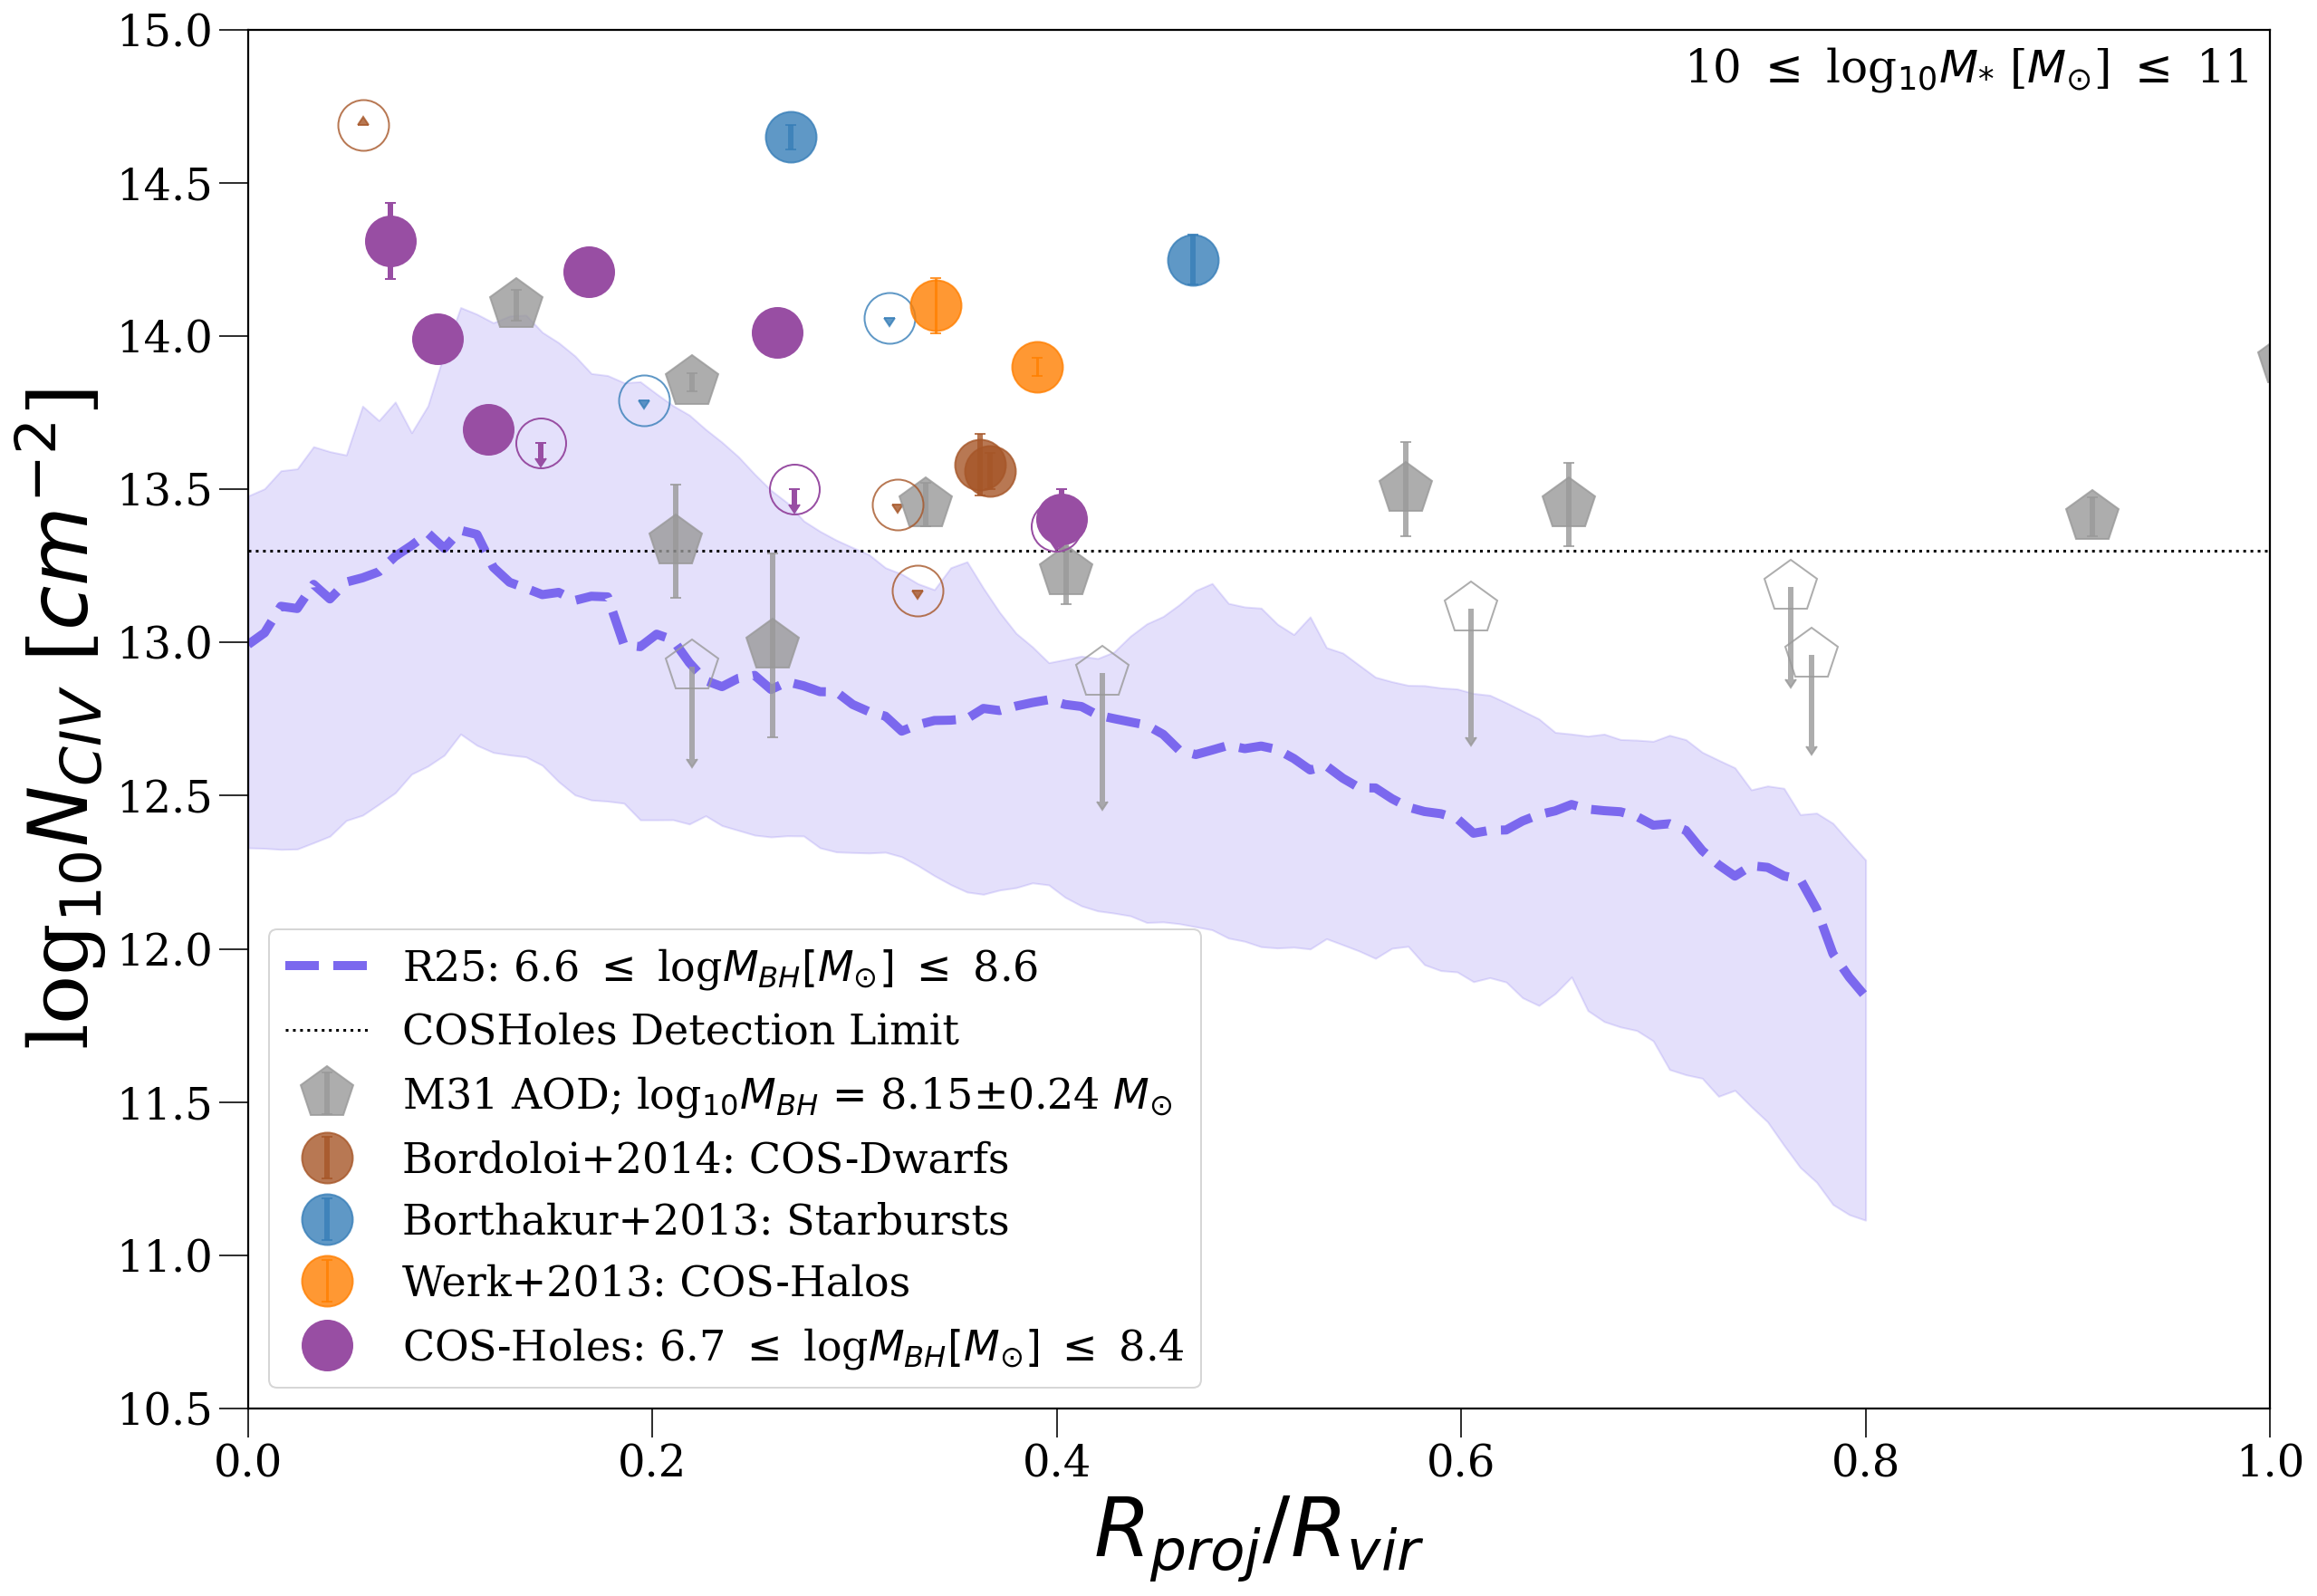

In [16]:
#Plotting NCIV vs Rproj/Rvir (this has the new data from Nicole in it) 

fig, ax = plt.subplots()

########################################################

#R25

plt.fill_between(r25_rr['Rproj/Rvir'], all_r25_16['16per'], all_r25_84['84per'], alpha = 0.2, color = 'mediumslateblue')
plt.plot(r25_rr['Rproj/Rvir'], all_r25_civ['logNciv'], 
         c = 'mediumslateblue', linewidth = 5, ls = '--', label = 'R25: 6.6 $\leq$ log$M_{BH} [M_{\odot}]$ $\leq$ 8.6')

########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 

##### M31 Detections (Sums) 
plt.errorbar (amiga_det_RRvir, amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = CB_color_cycle[6], 
              alpha=0.8, marker="p", markersize=30, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24 $M_{\odot}$', ls='none', elinewidth=3)

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_up_RRvir, amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = CB_color_cycle[6], 
              alpha =0.8, marker="p",mfc='none',markersize=30, ls='none', elinewidth=3)

########################################################

########## Literature Data ##########

############### Stellar Mass (10-11) Literature Sample ##############

#Non-Detections
    #Bordoloi
plt.errorbar(bordoloi_high['R/Rvir'][:2], bordoloi_high['logNCIV'][:2], yerr = bordoloi_high['err'][:2], capsize=3,c=CB_color_cycle[4], 
            alpha=0.8, marker = 'o', markersize = 28, ls='none', mfc='none', uplims=True, elinewidth=3) #upper limit

    #Borthakur 
plt.errorbar(borthakur_high['rhokpc[i]/rvir[i]'][:2], borthakur_high['logNCIV[i]'][:2], yerr = borthakur_high['err'][:2], capsize=3, 
                c = CB_color_cycle[0], alpha=0.8, marker = 'o', markersize = 28, ls='none', mfc='none', uplims=True, elinewidth=3) #upper limit
#Detections
    #Bordoloi
plt.errorbar(bordoloi_high['R/Rvir'][2:4], bordoloi_high['logNCIV'][2:4], yerr = bordoloi_high['err'][2:4], capsize=3, c=CB_color_cycle[4], 
            alpha=0.8, marker = 'o', markersize = 28, ls='none', label = 'Bordoloi+2014: COS-Dwarfs', elinewidth=3)
plt.errorbar(bordoloi_high['R/Rvir'][4:], bordoloi_high['logNCIV'][4:], yerr = bordoloi_high['err'][4:], capsize=3, c =CB_color_cycle[4], 
            alpha=0.8, marker = 'o', markersize = 28, ls='none', mfc='none', lolims=True, elinewidth=3) #lower limit 
    #Borthakur
plt.errorbar(borthakur_high['rhokpc[i]/rvir[i]'][2:], borthakur_high['logNCIV[i]'][2:], yerr = borthakur_high['err'][2:], capsize=3, 
                alpha=0.8, c = CB_color_cycle[0], marker = 'o', markersize = 28, ls='none', label = 'Borthakur+2013: Starbursts', elinewidth=3) 

#######COS-Halos 
#Detections
plt.errorbar(COSHALOS['Rproj/Rvir'], COSHALOS['NCIV'], yerr = COSHALOS['sigNCIV'], capsize=3, c = CB_color_cycle[1], label = 'Werk+2013: COS-Halos', 
             marker = 'o', markersize=28, ls='none', alpha=0.8)

########################################################

plt.axhline(13.3, c='k', ls=':', label='COSHoles Detection Limit')

for colour, label in zip([CB_color_cycle[5]], [r"COS-Holes: 6.7 $\leq$ log$M_{BH} [M_{\odot}]$ $\leq$ 8.4"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"], sum_ch['N'],yerr=sum_ch['sigN'], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj/Rvir"], up_ch['N'], yerr=up_ch['sigN'], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

plt.annotate('10 $\leq$ log$_{10}M_{*}$ [$M_{\odot}$] $\leq$ 11', (0.71, 14.83), fontsize=25)
ax.legend(loc=3, fontsize=23)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(10.5, 15)
ax.set_xlim(0, 1)
#plt.savefig('Figures/nciv_r25sum_vs_rr.png')
plt.show()

<>:10: DeprecationWarning: invalid escape sequence \o
<>:17: DeprecationWarning: invalid escape sequence \l
<>:33: DeprecationWarning: invalid escape sequence \o
<>:82: DeprecationWarning: invalid escape sequence \l
<>:10: DeprecationWarning: invalid escape sequence \o
<>:17: DeprecationWarning: invalid escape sequence \l
<>:33: DeprecationWarning: invalid escape sequence \o
<>:82: DeprecationWarning: invalid escape sequence \l
<>:10: DeprecationWarning: invalid escape sequence \o
<>:17: DeprecationWarning: invalid escape sequence \l
<>:33: DeprecationWarning: invalid escape sequence \o
<>:82: DeprecationWarning: invalid escape sequence \l
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_6109/3659470762.py:10: DeprecationWarning: invalid escape sequence \o
  plt.plot(df_r_new_lowtng['#R(kpc)'], df_r_new_lowtng['median'], color ='mediumorchid', lw = 5, ls = 'dashdot', label = 'TNG: log$M_{BH}/M_{\odot}$ = 6.0-8.2; n=1059')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipyke

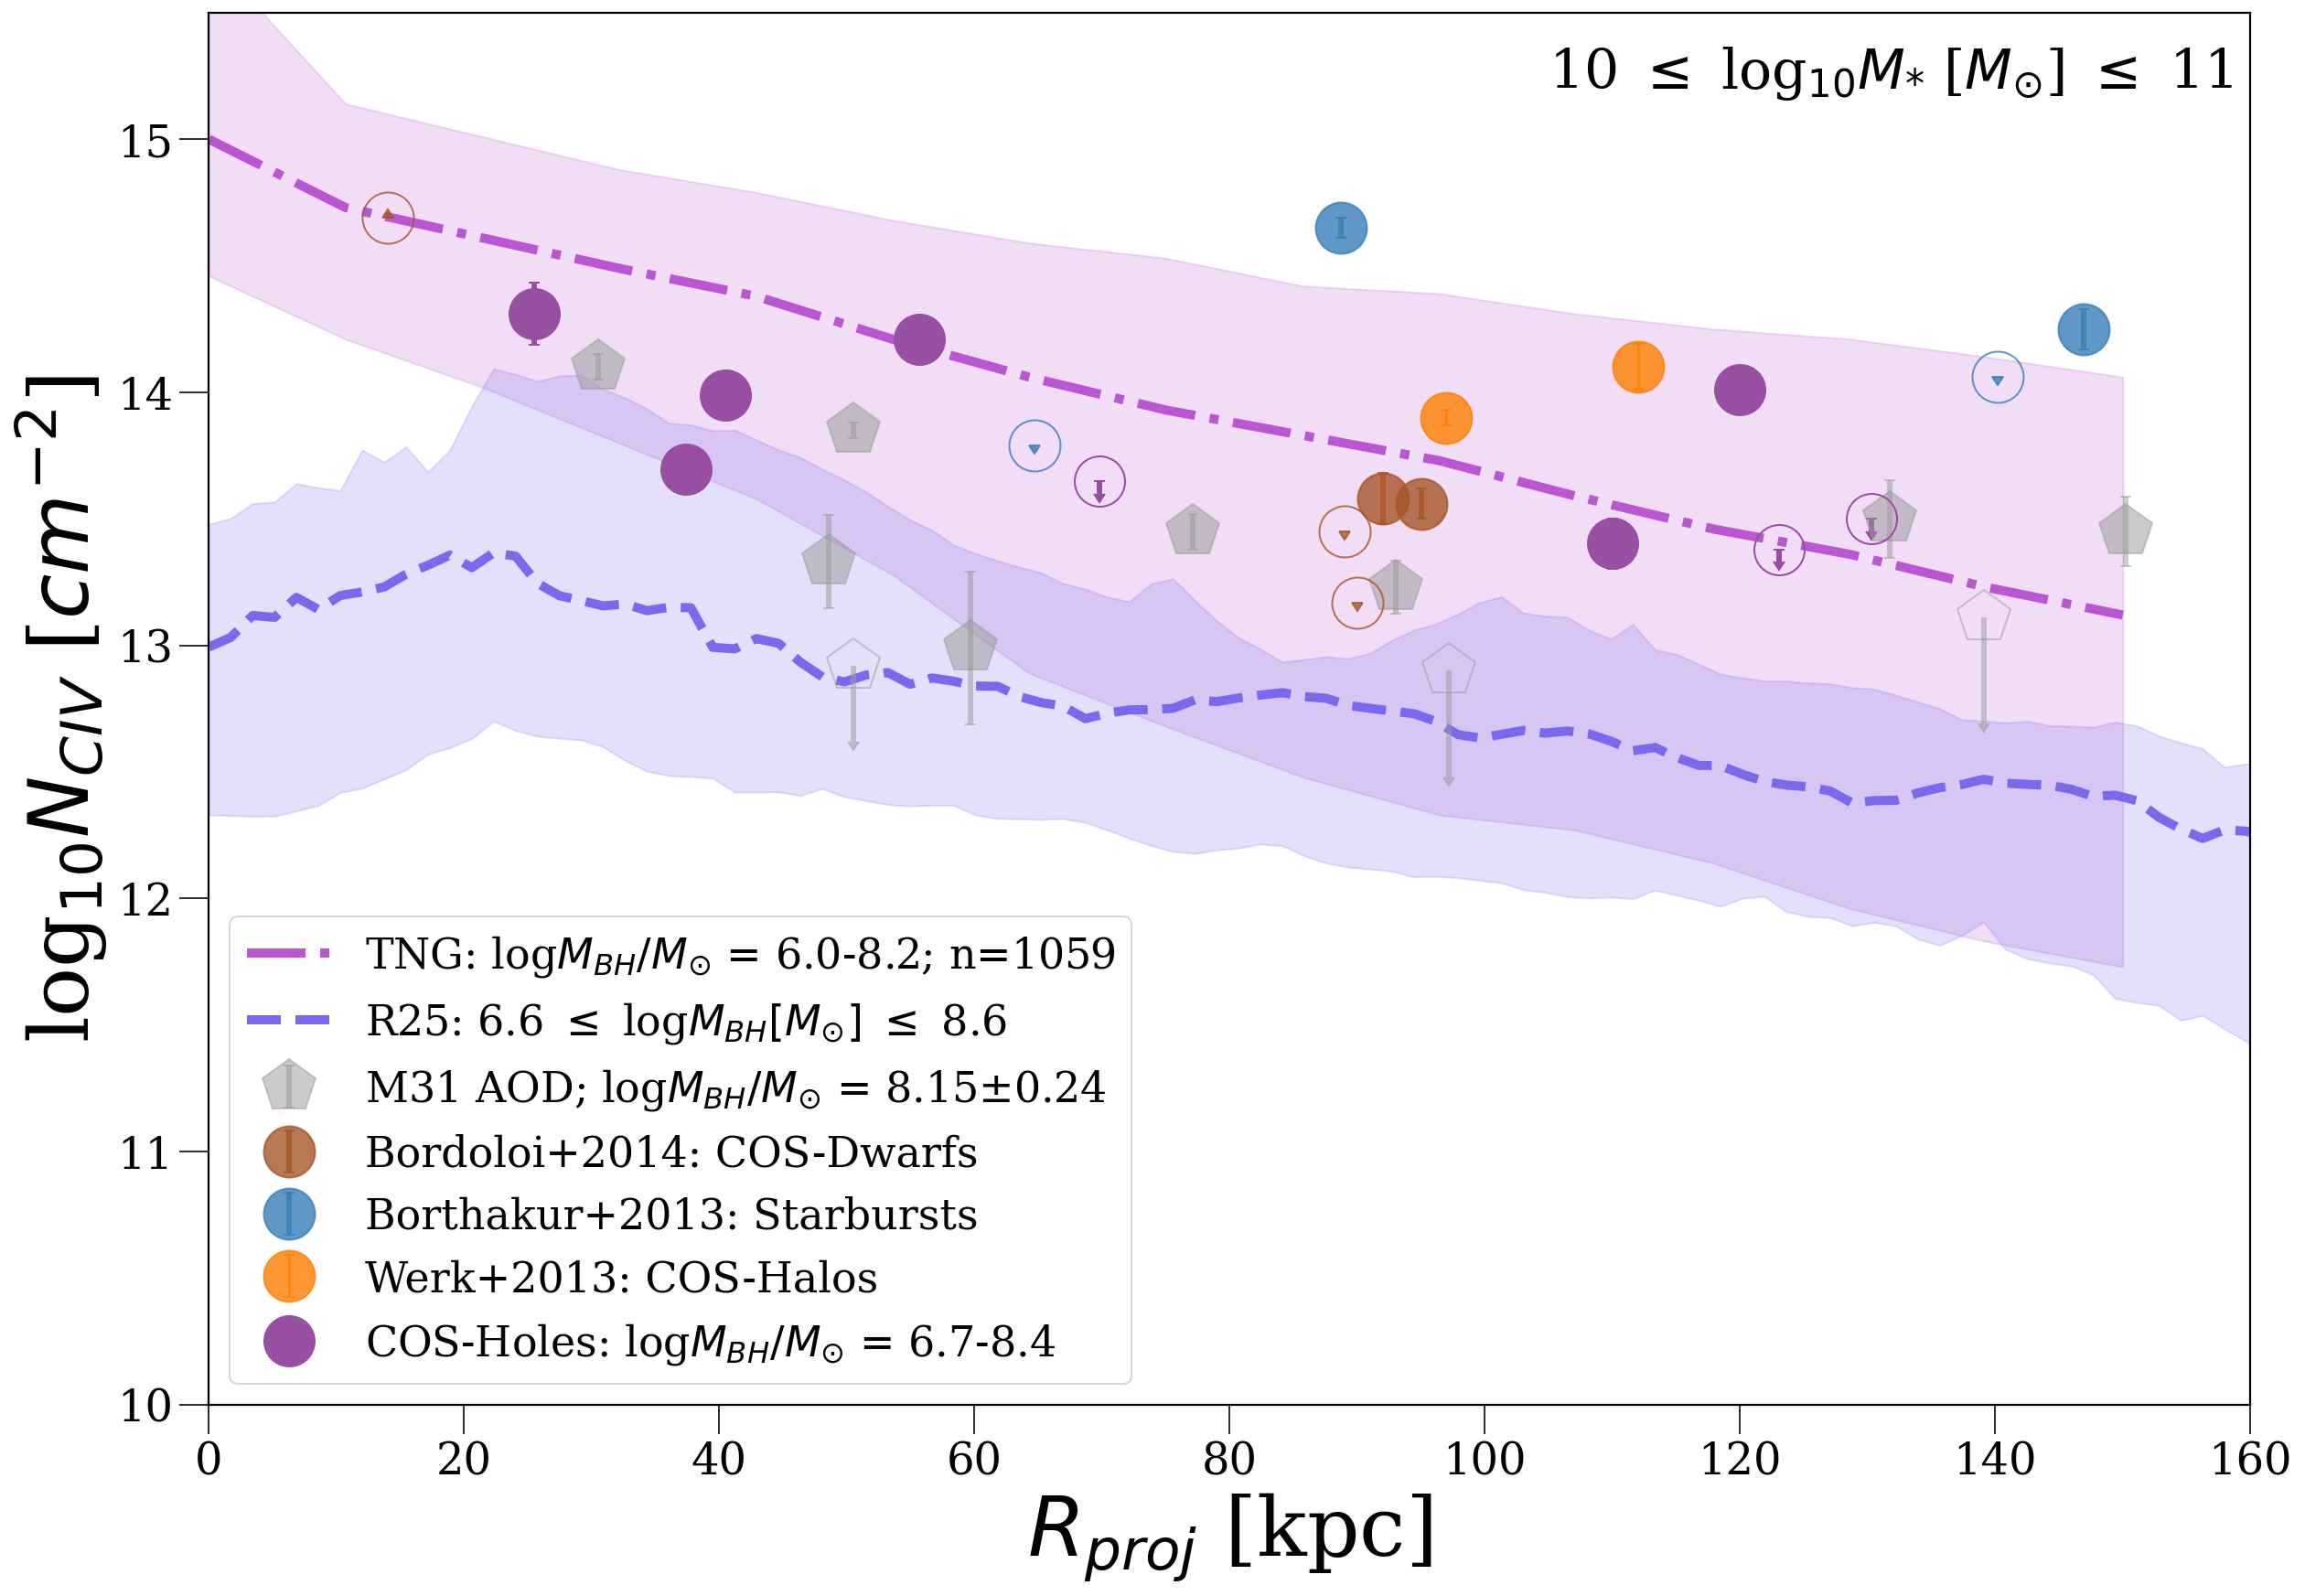

In [17]:
#Plotting NCIV vs Rproj/Rvir Just One large sample instead of high and low with both simulations on there 

fig, ax = plt.subplots()

########################################################

#TNG

plt.fill_between(df_r_new_lowtng['#R(kpc)'], df_r_new_lowtng['16percentile'], df_r_new_lowtng['84percentile'], alpha = 0.2, color = 'mediumorchid')
plt.plot(df_r_new_lowtng['#R(kpc)'], df_r_new_lowtng['median'], color ='mediumorchid', lw = 5, ls = 'dashdot', label = 'TNG: log$M_{BH}/M_{\odot}$ = 6.0-8.2; n=1059')


#R25

plt.fill_between(r25_r['Rproj'], all_r25_16['16per'], all_r25_84['84per'], alpha = 0.2, color = 'mediumslateblue')
plt.plot(r25_r['Rproj'], all_r25_civ['logNciv'], 
         c = 'mediumslateblue', linewidth = 5, ls = '--', label = 'R25: 6.6 $\leq$ log$M_{BH} [M_{\odot}]$ $\leq$ 8.6')

#EAGLE

#plt.fill_between(df_r_eagle['#R(kpc)'], df_r_eagle['16percentile'], df_r_eagle['84percentile'], alpha = 0.5, 
#                 color = 'mediumpurple')
#plt.plot(df_r_eagle['#R(kpc)'], df_r_eagle['median'], 
#         color = 'mediumpurple', lw = 5, label = 'EAGLE:  log$M_{BH}/M_{\odot}$ = 6.6-8.6')

########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 , used lightgrey before 

##### M31 Detections (Sums) 
plt.errorbar (amiga_2_det_sum['Rad'], amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = CB_color_cycle[6], 
              alpha = 0.5, marker="p", markersize=30, label='M31 AOD; log$M_{BH}/M_{\odot}$ = 8.15$\pm$0.24 ', ls='none', elinewidth=3)

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_2_up_sum['Rad'], amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = CB_color_cycle[6], 
              alpha =0.5, marker="p",mfc='none',markersize=30, ls='none', elinewidth=3)

########################################################

########## Literature Data ##########


############### Stellar Mass (10-11) Literature Sample ##############

#Non-Detections
    #Bordoloi
plt.errorbar(bordoloi_high['R[kpc]'][:2], bordoloi_high['logNCIV'][:2], yerr = bordoloi_high['err'][:2], capsize=3, c=CB_color_cycle[4], 
            alpha=0.8, marker = 'o', markersize = 28, ls='none', mfc='none', uplims=True, elinewidth=3) #upper limit

    #Borthakur 
plt.errorbar(borthakur_high['rhokpc[i]'][:2], borthakur_high['logNCIV[i]'][:2], yerr = borthakur_high['err'][:2], capsize=3, 
                c = CB_color_cycle[0], alpha=0.8, marker = 'o', markersize = 28, ls='none', mfc='none', uplims=True, elinewidth=3) #upper limit
#Detections
    #Bordoloi
plt.errorbar(bordoloi_high['R[kpc]'][2:4], bordoloi_high['logNCIV'][2:4], yerr = bordoloi_high['err'][2:4], capsize=3, c=CB_color_cycle[4], 
            alpha=0.8, marker = 'o', markersize = 28, ls='none', label = 'Bordoloi+2014: COS-Dwarfs', elinewidth=3)
plt.errorbar(bordoloi_high['R[kpc]'][4:], bordoloi_high['logNCIV'][4:], yerr = bordoloi_high['err'][4:], capsize=3, c =CB_color_cycle[4], 
            alpha=0.8, marker = 'o', markersize = 28, ls='none', mfc='none', lolims=True, elinewidth=3) #lower limit 
   
    #Borthakur
plt.errorbar(borthakur_high['rhokpc[i]'][2:], borthakur_high['logNCIV[i]'][2:], yerr = borthakur_high['err'][2:], capsize=3, 
                alpha=0.8, c = CB_color_cycle[0], marker = 'o', markersize = 28, ls='none', label = 'Borthakur+2013: Starbursts', elinewidth=3) 

#######COS-Halos 
#Detections
plt.errorbar(COSHALOS['Rproj'], COSHALOS['NCIV'], yerr = COSHALOS['sigNCIV'], capsize=3, c = CB_color_cycle[1], label = 'Werk+2013: COS-Halos', 
             marker = 'o', markersize=28, ls='none', alpha=0.8)

########################################################

#plt.axhline(13.3, c='k', ls=':', label='COSHoles Detection Limit')

for colour, label in zip([CB_color_cycle[5]], [r"COS-Holes: log$M_{BH}/M_{\odot}$ = 6.7-8.4"]):
    
    ax.errorbar(sum_ch["Rproj"], sum_ch['N'],yerr=sum_ch['sigN'], 
                capsize = 3, c = colour, marker=".", markersize=55, label=label, ls='none', elinewidth=3)
    
    ax.errorbar(up_ch["Rproj"], up_ch['N'], yerr=up_ch['sigN'], 
                capsize = 3, c = colour, marker=".", markersize=55, ls='none', uplims=True, mfc='none', elinewidth=3)

plt.annotate('10 $\leq$ log$_{10}M_{*}$ [$M_{\odot}$] $\leq$ 11', (105, 15.2), fontsize=30)
ax.legend(loc=3, fontsize=23)
ax.set_xlabel(r"$R_{proj}$ [kpc]", fontsize=45)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
ax.set_ylim(10, 15.5)
ax.set_xlim(0, 160)
#plt.savefig('Figures/nciv_oneradall_vs_r.png')
plt.show()

## STATS for all MBH sample for Sims comapred to COS-Holes Data

### R25